<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Background_subtract() for MIRI LRS SLIT
<span style="color:red"> **Instruments Affected**</span>: MIRI

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.


* astropy.io for opening fits files
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot
* shutil, glob for basic OS operations

* pysiaf for retrieving SIAF information
* miricoord for coordinate transformations
* ci_watson for retrieval from artifactory


[Top of Page](#title_ID)

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.stats as stats
import numpy as np
from glob import glob
import shutil
import os
import logging

%matplotlib inline

from jwst.pipeline import Spec2Pipeline, Detector1Pipeline
from jwst.assign_wcs import AssignWcsStep
from jwst.background import BackgroundStep
from jwst import datamodels
from jwst.datamodels import ImageModel
import pysiaf
import miricoord.imager.mirim_tools as mt


from ci_watson.artifactory_helpers import get_bigdata

<a id="intro_ID"></a>
# Introduction


For this test we are using the background subtraction step for MIRI LRS slit data. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/background/description.html

Pipeline code: https://github.com/spacetelescope/jwst/blob/master/jwst/background/



### Defining Term
Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

JWST: James Webb Space Telescope
MIRI: Mid-Infrared Instrument
LRS: Low Resolution Spectrometer


[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data and initial processing

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 

[Top of Page](#title_ID)

In [2]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

In [3]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]

Now run pipeline stage Detector1() and step Assignwcs() for initial processing, on both files.

In [4]:
det1_out = []
nods = []
for ff in files:
    det1 = Detector1Pipeline.call(ff, save_results=True)
    if 'nod1' in ff:
        nodno = 'nod1'
    else:
        nodno = 'nod2'
    det1_out.append(det1)
    nods.append(nodno)

2021-02-18 22:12:24,632 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap       694 bytes  (1 / 141 files) (0 / 390.2 K bytes)


2021-02-18 22:12:24,669 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_calver_0024.rmap      2.8 K bytes  (2 / 141 files) (694 / 390.2 K bytes)


2021-02-18 22:12:24,707 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_system_0023.imap               385 bytes  (3 / 141 files) (3.4 K / 390.2 K bytes)


2021-02-18 22:12:24,739 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0017.rmap    1.1 K bytes  (4 / 141 files) (3.8 K / 390.2 K bytes)


2021-02-18 22:12:24,769 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0003.rmap      833 bytes  (5 / 141 files) (4.9 K / 390.2 K bytes)


2021-02-18 22:12:24,801 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_superbias_0039.rmap   15.9 K bytes  (6 / 141 files) (5.8 K / 390.2 K bytes)


2021-02-18 22:12:24,833 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_sflat_0011.rmap     19.3 K bytes  (7 / 141 files) (21.7 K / 390.2 K bytes)


2021-02-18 22:12:24,864 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_saturation_0017.rmap    2.0 K bytes  (8 / 141 files) (40.9 K / 390.2 K bytes)


2021-02-18 22:12:24,895 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_refpix_0014.rmap     1.5 K bytes  (9 / 141 files) (42.9 K / 390.2 K bytes)


2021-02-18 22:12:24,924 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_readnoise_0020.rmap    2.3 K bytes  (10 / 141 files) (44.5 K / 390.2 K bytes)


2021-02-18 22:12:24,956 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_photom_0012.rmap       907 bytes  (11 / 141 files) (46.8 K / 390.2 K bytes)


2021-02-18 22:12:24,987 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pathloss_0003.rmap      932 bytes  (12 / 141 files) (47.7 K / 390.2 K bytes)


2021-02-18 22:12:25,021 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0004.rmap    1.8 K bytes  (13 / 141 files) (48.6 K / 390.2 K bytes)


2021-02-18 22:12:25,053 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ote_0020.rmap        1.0 K bytes  (14 / 141 files) (50.5 K / 390.2 K bytes)


2021-02-18 22:12:25,085 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_msaoper_0003.rmap      783 bytes  (15 / 141 files) (51.5 K / 390.2 K bytes)


2021-02-18 22:12:25,115 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_msa_0018.rmap        1.0 K bytes  (16 / 141 files) (52.3 K / 390.2 K bytes)


2021-02-18 22:12:25,145 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_mask_0021.rmap       1.5 K bytes  (17 / 141 files) (53.3 K / 390.2 K bytes)


2021-02-18 22:12:25,177 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (18 / 141 files) (54.7 K / 390.2 K bytes)


2021-02-18 22:12:25,210 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ipc_0006.rmap          876 bytes  (19 / 141 files) (56.3 K / 390.2 K bytes)


2021-02-18 22:12:25,242 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifuslicer_0008.rmap    1.0 K bytes  (20 / 141 files) (57.2 K / 390.2 K bytes)


2021-02-18 22:12:25,269 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifupost_0010.rmap      991 bytes  (21 / 141 files) (58.2 K / 390.2 K bytes)


2021-02-18 22:12:25,297 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_ifufore_0008.rmap      991 bytes  (22 / 141 files) (59.2 K / 390.2 K bytes)


2021-02-18 22:12:25,329 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_gain_0019.rmap       1.8 K bytes  (23 / 141 files) (60.2 K / 390.2 K bytes)


2021-02-18 22:12:25,367 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fpa_0019.rmap        1.0 K bytes  (24 / 141 files) (61.9 K / 390.2 K bytes)


2021-02-18 22:12:25,399 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fore_0017.rmap       3.4 K bytes  (25 / 141 files) (63.0 K / 390.2 K bytes)


2021-02-18 22:12:25,428 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_flat_0014.rmap       3.8 K bytes  (26 / 141 files) (66.4 K / 390.2 K bytes)


2021-02-18 22:12:25,457 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_fflat_0009.rmap      3.3 K bytes  (27 / 141 files) (70.2 K / 390.2 K bytes)


2021-02-18 22:12:25,484 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_extract1d_0012.rmap    1.2 K bytes  (28 / 141 files) (73.5 K / 390.2 K bytes)


2021-02-18 22:12:25,516 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_disperser_0019.rmap    3.9 K bytes  (29 / 141 files) (74.7 K / 390.2 K bytes)


2021-02-18 22:12:25,548 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_dflat_0006.rmap      1.1 K bytes  (30 / 141 files) (78.7 K / 390.2 K bytes)


2021-02-18 22:12:25,579 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_dark_0032.rmap      14.5 K bytes  (31 / 141 files) (79.7 K / 390.2 K bytes)


2021-02-18 22:12:25,610 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_cubepar_0007.rmap      915 bytes  (32 / 141 files) (94.3 K / 390.2 K bytes)


2021-02-18 22:12:25,640 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_collimator_0017.rmap    1.1 K bytes  (33 / 141 files) (95.2 K / 390.2 K bytes)


2021-02-18 22:12:25,669 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_camera_0017.rmap     1.0 K bytes  (34 / 141 files) (96.2 K / 390.2 K bytes)


2021-02-18 22:12:25,704 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_barshadow_0003.rmap      877 bytes  (35 / 141 files) (97.3 K / 390.2 K bytes)


2021-02-18 22:12:25,734 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_area_0014.rmap       4.5 K bytes  (36 / 141 files) (98.1 K / 390.2 K bytes)


2021-02-18 22:12:25,765 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_apcorr_0005.rmap     5.3 K bytes  (37 / 141 files) (102.6 K / 390.2 K bytes)


2021-02-18 22:12:25,797 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nirspec_0217.imap            4.8 K bytes  (38 / 141 files) (107.9 K / 390.2 K bytes)


2021-02-18 22:12:25,825 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_wfssbkg_0002.rmap     2.3 K bytes  (39 / 141 files) (112.7 K / 390.2 K bytes)


2021-02-18 22:12:25,855 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_wavelengthrange_0005.rmap      811 bytes  (40 / 141 files) (115.0 K / 390.2 K bytes)


2021-02-18 22:12:25,885 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (41 / 141 files) (115.8 K / 390.2 K bytes)


2021-02-18 22:12:25,916 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_trapdensity_0004.rmap      774 bytes  (42 / 141 files) (116.5 K / 390.2 K bytes)


2021-02-18 22:12:25,947 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_throughput_0004.rmap      979 bytes  (43 / 141 files) (117.3 K / 390.2 K bytes)


2021-02-18 22:12:25,977 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_superbias_0022.rmap    4.6 K bytes  (44 / 141 files) (118.3 K / 390.2 K bytes)


2021-02-18 22:12:26,007 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_specwcs_0005.rmap     2.3 K bytes  (45 / 141 files) (122.9 K / 390.2 K bytes)


2021-02-18 22:12:26,037 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_saturation_0011.rmap      693 bytes  (46 / 141 files) (125.2 K / 390.2 K bytes)


2021-02-18 22:12:26,069 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_readnoise_0008.rmap      969 bytes  (47 / 141 files) (125.9 K / 390.2 K bytes)


2021-02-18 22:12:26,101 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_photom_0026.rmap        996 bytes  (48 / 141 files) (126.8 K / 390.2 K bytes)


2021-02-18 22:12:26,134 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_persat_0005.rmap        738 bytes  (49 / 141 files) (127.8 K / 390.2 K bytes)


2021-02-18 22:12:26,166 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pathloss_0002.rmap      707 bytes  (50 / 141 files) (128.6 K / 390.2 K bytes)


2021-02-18 22:12:26,198 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-tweakregstep_0003.rmap    2.2 K bytes  (51 / 141 files) (129.3 K / 390.2 K bytes)


2021-02-18 22:12:26,229 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_pars-image2pipeline_0002.rmap      712 bytes  (52 / 141 files) (131.5 K / 390.2 K bytes)


2021-02-18 22:12:26,261 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_mask_0017.rmap          735 bytes  (53 / 141 files) (132.2 K / 390.2 K bytes)


2021-02-18 22:12:26,291 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_linearity_0016.rmap      827 bytes  (54 / 141 files) (133.0 K / 390.2 K bytes)


2021-02-18 22:12:26,320 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_ipc_0006.rmap           590 bytes  (55 / 141 files) (133.8 K / 390.2 K bytes)


2021-02-18 22:12:26,349 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_gain_0010.rmap          838 bytes  (56 / 141 files) (134.4 K / 390.2 K bytes)


2021-02-18 22:12:26,380 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_flat_0019.rmap        4.1 K bytes  (57 / 141 files) (135.2 K / 390.2 K bytes)


2021-02-18 22:12:26,411 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_extract1d_0006.rmap      854 bytes  (58 / 141 files) (139.4 K / 390.2 K bytes)


2021-02-18 22:12:26,443 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (59 / 141 files) (140.2 K / 390.2 K bytes)


2021-02-18 22:12:26,479 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_distortion_0017.rmap      899 bytes  (60 / 141 files) (140.7 K / 390.2 K bytes)


2021-02-18 22:12:26,512 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_dark_0027.rmap        4.0 K bytes  (61 / 141 files) (141.6 K / 390.2 K bytes)


2021-02-18 22:12:26,542 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_area_0012.rmap        1.1 K bytes  (62 / 141 files) (145.6 K / 390.2 K bytes)


2021-02-18 22:12:26,574 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_apcorr_0004.rmap      4.1 K bytes  (63 / 141 files) (146.7 K / 390.2 K bytes)


2021-02-18 22:12:26,608 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_abvegaoffset_0002.rmap    1.3 K bytes  (64 / 141 files) (150.8 K / 390.2 K bytes)


2021-02-18 22:12:26,641 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_niriss_0139.imap             4.6 K bytes  (65 / 141 files) (152.1 K / 390.2 K bytes)


2021-02-18 22:12:26,672 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_wfssbkg_0003.rmap     7.2 K bytes  (66 / 141 files) (156.7 K / 390.2 K bytes)


2021-02-18 22:12:26,703 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_wavelengthrange_0009.rmap      945 bytes  (67 / 141 files) (163.9 K / 390.2 K bytes)


2021-02-18 22:12:26,733 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_tsophot_0002.rmap       794 bytes  (68 / 141 files) (164.8 K / 390.2 K bytes)


2021-02-18 22:12:26,761 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (69 / 141 files) (165.6 K / 390.2 K bytes)


2021-02-18 22:12:26,784 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (70 / 141 files) (167.2 K / 390.2 K bytes)


2021-02-18 22:12:26,808 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_superbias_0006.rmap    2.6 K bytes  (71 / 141 files) (168.8 K / 390.2 K bytes)


2021-02-18 22:12:26,834 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_specwcs_0008.rmap     1.7 K bytes  (72 / 141 files) (171.4 K / 390.2 K bytes)


2021-02-18 22:12:26,863 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_saturation_0006.rmap    2.2 K bytes  (73 / 141 files) (173.1 K / 390.2 K bytes)


2021-02-18 22:12:26,893 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_readnoise_0006.rmap    5.6 K bytes  (74 / 141 files) (175.2 K / 390.2 K bytes)


2021-02-18 22:12:26,925 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_psfmask_0005.rmap    10.7 K bytes  (75 / 141 files) (180.8 K / 390.2 K bytes)


2021-02-18 22:12:26,957 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_photom_0010.rmap      4.3 K bytes  (76 / 141 files) (191.6 K / 390.2 K bytes)


2021-02-18 22:12:26,986 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_persat_0004.rmap      1.6 K bytes  (77 / 141 files) (195.9 K / 390.2 K bytes)


2021-02-18 22:12:27,016 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_pars-tweakregstep_0002.rmap    4.5 K bytes  (78 / 141 files) (197.5 K / 390.2 K bytes)


2021-02-18 22:12:27,047 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_mask_0007.rmap        2.3 K bytes  (79 / 141 files) (201.9 K / 390.2 K bytes)


2021-02-18 22:12:27,077 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (80 / 141 files) (204.2 K / 390.2 K bytes)


2021-02-18 22:12:27,107 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_ipc_0003.rmap         2.0 K bytes  (81 / 141 files) (206.6 K / 390.2 K bytes)


2021-02-18 22:12:27,137 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_gain_0010.rmap        2.3 K bytes  (82 / 141 files) (208.6 K / 390.2 K bytes)


2021-02-18 22:12:27,169 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_flat_0016.rmap       28.9 K bytes  (83 / 141 files) (210.9 K / 390.2 K bytes)


2021-02-18 22:12:27,200 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_filteroffset_0003.rmap    1.1 K bytes  (84 / 141 files) (239.7 K / 390.2 K bytes)


2021-02-18 22:12:27,232 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (85 / 141 files) (240.9 K / 390.2 K bytes)


2021-02-18 22:12:27,263 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_distortion_0022.rmap    9.1 K bytes  (86 / 141 files) (241.4 K / 390.2 K bytes)


2021-02-18 22:12:27,296 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_dark_0021.rmap       14.2 K bytes  (87 / 141 files) (250.5 K / 390.2 K bytes)


2021-02-18 22:12:27,326 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_area_0006.rmap        4.6 K bytes  (88 / 141 files) (264.7 K / 390.2 K bytes)


2021-02-18 22:12:27,358 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_apcorr_0007.rmap      4.2 K bytes  (89 / 141 files) (269.3 K / 390.2 K bytes)


2021-02-18 22:12:27,388 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_abvegaoffset_0002.rmap    1.3 K bytes  (90 / 141 files) (273.5 K / 390.2 K bytes)


2021-02-18 22:12:27,420 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_nircam_0149.imap             4.5 K bytes  (91 / 141 files) (274.8 K / 390.2 K bytes)


2021-02-18 22:12:27,450 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_wcsregions_0009.rmap    1.1 K bytes  (92 / 141 files) (279.3 K / 390.2 K bytes)


2021-02-18 22:12:27,479 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_wavelengthrange_0020.rmap    1.1 K bytes  (93 / 141 files) (280.4 K / 390.2 K bytes)


2021-02-18 22:12:27,508 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_tsophot_0002.rmap         780 bytes  (94 / 141 files) (281.5 K / 390.2 K bytes)


2021-02-18 22:12:27,539 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_straymask_0007.rmap       885 bytes  (95 / 141 files) (282.3 K / 390.2 K bytes)


2021-02-18 22:12:27,571 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_specwcs_0026.rmap       4.0 K bytes  (96 / 141 files) (283.2 K / 390.2 K bytes)


2021-02-18 22:12:27,602 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_saturation_0012.rmap      961 bytes  (97 / 141 files) (287.1 K / 390.2 K bytes)


2021-02-18 22:12:27,633 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_rscd_0006.rmap            860 bytes  (98 / 141 files) (288.1 K / 390.2 K bytes)


2021-02-18 22:12:27,664 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_resol_0004.rmap           739 bytes  (99 / 141 files) (289.0 K / 390.2 K bytes)


2021-02-18 22:12:27,695 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_reset_0012.rmap         2.2 K bytes  (100 / 141 files) (289.7 K / 390.2 K bytes)


2021-02-18 22:12:27,728 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_regions_0026.rmap       3.6 K bytes  (101 / 141 files) (291.9 K / 390.2 K bytes)


2021-02-18 22:12:27,758 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_readnoise_0015.rmap     3.3 K bytes  (102 / 141 files) (295.5 K / 390.2 K bytes)


2021-02-18 22:12:27,787 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_psfmask_0003.rmap       1.3 K bytes  (103 / 141 files) (298.8 K / 390.2 K bytes)


2021-02-18 22:12:27,820 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_photom_0030.rmap        5.5 K bytes  (104 / 141 files) (300.0 K / 390.2 K bytes)


2021-02-18 22:12:27,853 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_pars-tweakregstep_0002.rmap    1.8 K bytes  (105 / 141 files) (305.5 K / 390.2 K bytes)


2021-02-18 22:12:27,882 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_mask_0015.rmap            893 bytes  (106 / 141 files) (307.4 K / 390.2 K bytes)


2021-02-18 22:12:27,926 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_linearity_0013.rmap     1.9 K bytes  (107 / 141 files) (308.3 K / 390.2 K bytes)


2021-02-18 22:12:27,958 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_ipc_0005.rmap             721 bytes  (108 / 141 files) (310.2 K / 390.2 K bytes)


2021-02-18 22:12:27,987 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_gain_0007.rmap            893 bytes  (109 / 141 files) (310.9 K / 390.2 K bytes)


2021-02-18 22:12:28,016 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_fringe_0015.rmap        3.5 K bytes  (110 / 141 files) (311.8 K / 390.2 K bytes)


2021-02-18 22:12:28,048 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_flat_0048.rmap         21.9 K bytes  (111 / 141 files) (315.3 K / 390.2 K bytes)


2021-02-18 22:12:28,078 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_filteroffset_0020.rmap    1.1 K bytes  (112 / 141 files) (337.3 K / 390.2 K bytes)


2021-02-18 22:12:28,109 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_extract1d_0013.rmap     1.1 K bytes  (113 / 141 files) (338.4 K / 390.2 K bytes)


2021-02-18 22:12:28,140 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_drizpars_0002.rmap        511 bytes  (114 / 141 files) (339.5 K / 390.2 K bytes)


2021-02-18 22:12:28,171 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_distortion_0032.rmap    3.6 K bytes  (115 / 141 files) (340.0 K / 390.2 K bytes)


2021-02-18 22:12:28,202 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_dark_0021.rmap          3.2 K bytes  (116 / 141 files) (343.5 K / 390.2 K bytes)


2021-02-18 22:12:28,231 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_cubepar_0008.rmap         686 bytes  (117 / 141 files) (346.7 K / 390.2 K bytes)


2021-02-18 22:12:28,264 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_area_0011.rmap            755 bytes  (118 / 141 files) (347.4 K / 390.2 K bytes)


2021-02-18 22:12:28,294 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_apcorr_0007.rmap        4.3 K bytes  (119 / 141 files) (348.2 K / 390.2 K bytes)


2021-02-18 22:12:28,322 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_abvegaoffset_0002.rmap    1.3 K bytes  (120 / 141 files) (352.5 K / 390.2 K bytes)


2021-02-18 22:12:28,348 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_miri_0219.imap               4.6 K bytes  (121 / 141 files) (353.7 K / 390.2 K bytes)


2021-02-18 22:12:28,374 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_trappars_0004.rmap         903 bytes  (122 / 141 files) (358.3 K / 390.2 K bytes)


2021-02-18 22:12:28,403 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_trapdensity_0004.rmap      930 bytes  (123 / 141 files) (359.2 K / 390.2 K bytes)


2021-02-18 22:12:28,432 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_superbias_0015.rmap      3.8 K bytes  (124 / 141 files) (360.1 K / 390.2 K bytes)


2021-02-18 22:12:28,463 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_saturation_0009.rmap       779 bytes  (125 / 141 files) (363.9 K / 390.2 K bytes)


2021-02-18 22:12:28,495 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_readnoise_0011.rmap      1.3 K bytes  (126 / 141 files) (364.7 K / 390.2 K bytes)


2021-02-18 22:12:28,526 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_photom_0013.rmap         1.1 K bytes  (127 / 141 files) (366.0 K / 390.2 K bytes)


2021-02-18 22:12:28,558 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_persat_0004.rmap           884 bytes  (128 / 141 files) (367.1 K / 390.2 K bytes)


2021-02-18 22:12:28,589 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (129 / 141 files) (368.0 K / 390.2 K bytes)


2021-02-18 22:12:28,620 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_mask_0018.rmap           1.2 K bytes  (130 / 141 files) (368.8 K / 390.2 K bytes)


2021-02-18 22:12:28,653 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_linearity_0013.rmap        925 bytes  (131 / 141 files) (370.0 K / 390.2 K bytes)


2021-02-18 22:12:28,684 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_ipc_0003.rmap              614 bytes  (132 / 141 files) (370.9 K / 390.2 K bytes)


2021-02-18 22:12:28,714 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_gain_0010.rmap             890 bytes  (133 / 141 files) (371.5 K / 390.2 K bytes)


2021-02-18 22:12:28,743 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_flat_0009.rmap           1.1 K bytes  (134 / 141 files) (372.4 K / 390.2 K bytes)


2021-02-18 22:12:28,772 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_distortion_0007.rmap     1.1 K bytes  (135 / 141 files) (373.5 K / 390.2 K bytes)


2021-02-18 22:12:28,802 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_dark_0013.rmap           4.3 K bytes  (136 / 141 files) (374.6 K / 390.2 K bytes)


2021-02-18 22:12:28,835 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_area_0009.rmap           1.0 K bytes  (137 / 141 files) (378.9 K / 390.2 K bytes)


2021-02-18 22:12:28,864 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_apcorr_0002.rmap         4.1 K bytes  (138 / 141 files) (380.0 K / 390.2 K bytes)


2021-02-18 22:12:28,895 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (139 / 141 files) (384.1 K / 390.2 K bytes)


2021-02-18 22:12:28,925 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_fgs_0088.imap                4.3 K bytes  (140 / 141 files) (385.3 K / 390.2 K bytes)


2021-02-18 22:12:28,956 - CRDS - INFO -  Fetching  crds_cache/mappings/jwst/jwst_0676.pmap                      580 bytes  (141 / 141 files) (389.6 K / 390.2 K bytes)


2021-02-18 22:12:29,295 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-02-18 22:12:29,297 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-02-18 22:12:29,298 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-02-18 22:12:29,299 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-02-18 22:12:29,300 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-02-18 22:12:29,301 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-02-18 22:12:29,303 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-02-18 22:12:29,303 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-02-18 22:12:29,305 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-02-18 22:12:29,305 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-02-18 22:12:29,306 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-02-18 22:12:29,307 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-02-18 22:12:29,308 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-02-18 22:12:29,309 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-02-18 22:12:29,311 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-02-18 22:12:29,312 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-02-18 22:12:29,313 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-02-18 22:12:29,503 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt/miri_lrs_slit_pt_nod1_v2.3.fits',).


2021-02-18 22:12:29,512 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-02-18 22:12:29,663 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-18 22:12:29,670 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits    3.4 G bytes  (1 / 9 files) (0 / 3.7 G bytes)


2021-02-18 22:12:43,275 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits    4.2 M bytes  (2 / 9 files) (3.4 G / 3.7 G bytes)


2021-02-18 22:12:43,341 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits   14.4 K bytes  (3 / 9 files) (3.4 G / 3.7 G bytes)


2021-02-18 22:12:43,372 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits   46.5 M bytes  (4 / 9 files) (3.4 G / 3.7 G bytes)


2021-02-18 22:12:43,635 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits    4.2 M bytes  (5 / 9 files) (3.4 G / 3.7 G bytes)


2021-02-18 22:12:43,697 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits    4.2 M bytes  (6 / 9 files) (3.4 G / 3.7 G bytes)


2021-02-18 22:12:43,762 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_reset_0042.fits  205.0 M bytes  (7 / 9 files) (3.5 G / 3.7 G bytes)


2021-02-18 22:12:44,616 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits   37.4 K bytes  (8 / 9 files) (3.7 G / 3.7 G bytes)


2021-02-18 22:12:44,657 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits    9.5 M bytes  (9 / 9 files) (3.7 G / 3.7 G bytes)


2021-02-18 22:12:44,739 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is 'crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.


2021-02-18 22:12:44,740 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is 'crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.


2021-02-18 22:12:44,740 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits'.


2021-02-18 22:12:44,741 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is 'crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.


2021-02-18 22:12:44,741 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is 'crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits'.


2021-02-18 22:12:44,742 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-18 22:12:44,742 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is 'crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits'.


2021-02-18 22:12:44,743 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-02-18 22:12:44,743 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'crds_cache/references/jwst/miri/jwst_miri_reset_0042.fits'.


2021-02-18 22:12:44,743 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.


2021-02-18 22:12:44,744 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is 'crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.


2021-02-18 22:12:44,745 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-18 22:12:44,745 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-18 22:12:44,745 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-18 22:12:44,746 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-18 22:12:45,060 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:45,062 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:12:45,069 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-18 22:12:45,070 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-18 22:12:45,070 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-18 22:12:45,158 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:45,159 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:12:45,169 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits


2021-02-18 22:12:45,372 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-18 22:12:45,474 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:45,475 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:12:45,485 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits


2021-02-18 22:12:45,803 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-02-18 22:12:45,813 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-18 22:12:45,817 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-18 22:12:45,948 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:45,950 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:12:45,960 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits


2021-02-18 22:12:46,555 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-18 22:12:46,694 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:46,695 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:12:46,855 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-18 22:12:46,968 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:46,969 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:12:47,102 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-18 22:12:47,211 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:47,212 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:12:47,222 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file crds_cache/references/jwst/miri/jwst_miri_reset_0042.fits


2021-02-18 22:12:47,327 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-18 22:12:47,606 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-18 22:12:47,743 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:47,744 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:12:47,754 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2021-02-18 22:12:48,158 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-18 22:12:48,272 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:48,274 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt', 'type': 'baseline'}


2021-02-18 22:12:48,282 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits


2021-02-18 22:12:48,440 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-18 22:12:48,537 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:48,539 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt', 'dark_output': None}


2021-02-18 22:12:48,548 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits


2021-02-18 22:12:50,346 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2021-02-18 22:12:50,347 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-18 22:12:51,363 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-18 22:12:51,747 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:51,748 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-18 22:12:51,756 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-02-18 22:12:51,757 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-02-18 22:12:51,757 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-02-18 22:12:51,757 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-02-18 22:12:51,758 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-02-18 22:12:51,933 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2021-02-18 22:12:52,224 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2021-02-18 22:12:52,276 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-18 22:12:52,379 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:52,380 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt', 'rejection_threshold': 4.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-18 22:12:52,387 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-02-18 22:12:52,390 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2021-02-18 22:12:52,401 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2021-02-18 22:12:52,411 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-18 22:12:52,616 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-18 22:12:53,064 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-18 22:12:53,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 23802 pixels with at least one CR


2021-02-18 22:12:54,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-18 22:12:54,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 5253 pixels with at least one CR


2021-02-18 22:12:54,748 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.13073 sec


2021-02-18 22:12:54,750 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.362457


2021-02-18 22:12:54,753 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-18 22:12:54,867 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:12:54,869 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-18 22:12:54,879 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2021-02-18 22:12:54,889 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2021-02-18 22:12:54,898 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-18 22:12:54,898 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-18 22:12:54,982 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-18 22:12:54,983 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-18 22:12:57,082 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:12:57,983 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:12:58,803 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:12:59,616 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:08,122 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:08,305 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:10,114 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:10,997 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:11,477 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:11,648 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-18 22:13:12,382 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-18 22:13:13,061 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2021-02-18 22:13:13,061 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2021-02-18 22:13:13,095 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-18 22:13:13,207 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:13:13,208 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:13,224 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-18 22:13:13,224 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-18 22:13:13,225 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-18 22:13:13,289 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2021-02-18 22:13:13,290 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:13,306 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-18 22:13:13,306 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-18 22:13:13,307 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-18 22:13:13,378 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rateints.fits


2021-02-18 22:13:13,379 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-18 22:13:13,426 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rate.fits


2021-02-18 22:13:13,427 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-02-18 22:13:13,720 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-02-18 22:13:13,721 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-02-18 22:13:13,721 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-02-18 22:13:13,722 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-02-18 22:13:13,723 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-02-18 22:13:13,724 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-02-18 22:13:13,725 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-02-18 22:13:13,726 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-02-18 22:13:13,727 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-02-18 22:13:13,727 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-02-18 22:13:13,728 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-02-18 22:13:13,729 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-02-18 22:13:13,730 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-02-18 22:13:13,731 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-02-18 22:13:13,732 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-02-18 22:13:13,734 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-02-18 22:13:13,735 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-02-18 22:13:13,832 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt/miri_lrs_slit_pt_nod2_v2.3.fits',).


2021-02-18 22:13:13,840 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2021-02-18 22:13:13,961 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-02-18 22:13:13,965 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is 'crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits'.


2021-02-18 22:13:13,965 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is 'crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits'.


2021-02-18 22:13:13,966 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits'.


2021-02-18 22:13:13,966 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is 'crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits'.


2021-02-18 22:13:13,966 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is 'crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits'.


2021-02-18 22:13:13,967 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-02-18 22:13:13,967 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is 'crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits'.


2021-02-18 22:13:13,967 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2021-02-18 22:13:13,967 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'crds_cache/references/jwst/miri/jwst_miri_reset_0042.fits'.


2021-02-18 22:13:13,968 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.


2021-02-18 22:13:13,969 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is 'crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.


2021-02-18 22:13:13,969 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-02-18 22:13:13,969 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-02-18 22:13:13,969 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-02-18 22:13:13,970 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-02-18 22:13:14,159 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:14,160 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:14,167 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-02-18 22:13:14,167 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-02-18 22:13:14,168 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-02-18 22:13:14,226 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:14,227 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:14,236 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file crds_cache/references/jwst/miri/jwst_miri_mask_0023.fits


2021-02-18 22:13:14,333 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-02-18 22:13:14,404 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:14,405 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:14,413 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits


2021-02-18 22:13:14,694 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2021-02-18 22:13:14,704 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-02-18 22:13:14,707 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-02-18 22:13:14,794 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:14,796 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:14,804 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file crds_cache/references/jwst/miri/jwst_miri_ipc_0009.fits


2021-02-18 22:13:15,282 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-02-18 22:13:15,369 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:15,371 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:15,505 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-02-18 22:13:15,574 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:15,576 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:15,645 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-02-18 22:13:15,723 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:15,725 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:15,733 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file crds_cache/references/jwst/miri/jwst_miri_reset_0042.fits


2021-02-18 22:13:15,835 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESET_LARGE does not correspond to an existing DQ mnemonic, so will be ignored


2021-02-18 22:13:16,022 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-02-18 22:13:16,110 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:16,111 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:16,119 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file crds_cache/references/jwst/miri/jwst_miri_linearity_0024.fits


2021-02-18 22:13:16,461 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-02-18 22:13:16,546 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:16,547 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt', 'type': 'baseline'}


2021-02-18 22:13:16,556 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits


2021-02-18 22:13:16,712 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-02-18 22:13:16,791 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:16,792 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt', 'dark_output': None}


2021-02-18 22:13:16,800 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file crds_cache/references/jwst/miri/jwst_miri_dark_0058.fits


2021-02-18 22:13:18,638 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2021-02-18 22:13:18,639 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-02-18 22:13:19,431 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-02-18 22:13:19,829 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:19,831 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-02-18 22:13:19,838 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2021-02-18 22:13:19,839 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2021-02-18 22:13:19,839 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2021-02-18 22:13:19,839 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


2021-02-18 22:13:19,839 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2021-02-18 22:13:19,971 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2021-02-18 22:13:20,249 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2021-02-18 22:13:20,301 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-02-18 22:13:20,388 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:20,389 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt', 'rejection_threshold': 4.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}


2021-02-18 22:13:20,395 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2021-02-18 22:13:20,398 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2021-02-18 22:13:20,409 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2021-02-18 22:13:20,417 - stpipe.Detector1Pipeline.jump - INFO - Found 32 possible cores to use for jump detection 


2021-02-18 22:13:20,568 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-02-18 22:13:21,005 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-02-18 22:13:21,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 24049 pixels with at least one CR


2021-02-18 22:13:22,050 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-02-18 22:13:22,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 5352 pixels with at least one CR


2021-02-18 22:13:22,615 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 2.04637 sec


2021-02-18 22:13:22,617 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.221631


2021-02-18 22:13:22,620 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-02-18 22:13:22,714 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:22,715 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-02-18 22:13:22,726 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: crds_cache/references/jwst/miri/jwst_miri_readnoise_0057.fits


2021-02-18 22:13:22,735 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: crds_cache/references/jwst/miri/jwst_miri_gain_0008.fits


2021-02-18 22:13:22,744 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-02-18 22:13:22,744 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-02-18 22:13:22,815 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-02-18 22:13:22,816 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-02-18 22:13:24,855 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:25,760 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:26,576 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:27,382 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:27,876 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:36,390 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:36,575 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:38,340 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:39,198 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:39,679 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:1999: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  got_case = np.zeros((asize1*asize2), dtype=np.bool)



2021-02-18 22:13:39,839 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-18 22:13:40,566 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/ramp_fitting/utils.py:534: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pix_not_done = np.ones( npix, dtype=np.bool)  # initialize to True



2021-02-18 22:13:41,301 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 10


2021-02-18 22:13:41,301 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2021-02-18 22:13:41,333 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-02-18 22:13:41,440 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:41,442 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:41,458 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-18 22:13:41,458 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-18 22:13:41,459 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-18 22:13:41,524 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2021-02-18 22:13:41,525 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp9lbf2fnt'}


2021-02-18 22:13:41,541 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-02-18 22:13:41,542 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-02-18 22:13:41,543 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-02-18 22:13:41,612 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rateints.fits


2021-02-18 22:13:41,613 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-02-18 22:13:41,659 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rate.fits


2021-02-18 22:13:41,660 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


In [5]:
awcs_out = []

for dd in det1_out:
    awcs = AssignWcsStep.call(dd, save_results=True)
    awcs_out.append(awcs)

2021-02-18 22:13:41,664 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



2021-02-18 22:13:41,678 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-18 22:13:41,759 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2021-02-18 22:13:41,760 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-18 22:13:41,767 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf    9.9 K bytes  (1 / 1 files) (0 / 9.9 K bytes)


2021-02-18 22:13:41,802 - CRDS - INFO -  Fetching  crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits   46.1 K bytes  (1 / 1 files) (0 / 46.1 K bytes)


2021-02-18 22:13:41,979 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': 'crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': 'crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-18 22:13:42,026 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-18 22:13:42,030 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2021-02-18 22:13:42,030 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2021-02-18 22:13:42,030 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-18 22:13:42,140 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits


2021-02-18 22:13:42,141 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-02-18 22:13:42,153 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-18 22:13:42,237 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2021-02-18 22:13:42,238 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-18 22:13:42,382 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': 'crds_cache/references/jwst/miri/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': 'crds_cache/references/jwst/miri/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-18 22:13:42,419 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-02-18 22:13:42,423 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2021-02-18 22:13:42,423 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2021-02-18 22:13:42,423 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-18 22:13:42,528 - stpipe.AssignWcsStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits


2021-02-18 22:13:42,529 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


In [6]:
print(awcs_out)
print(nods)

2021-02-18 22:13:42,533 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits>]
['nod1', 'nod2']


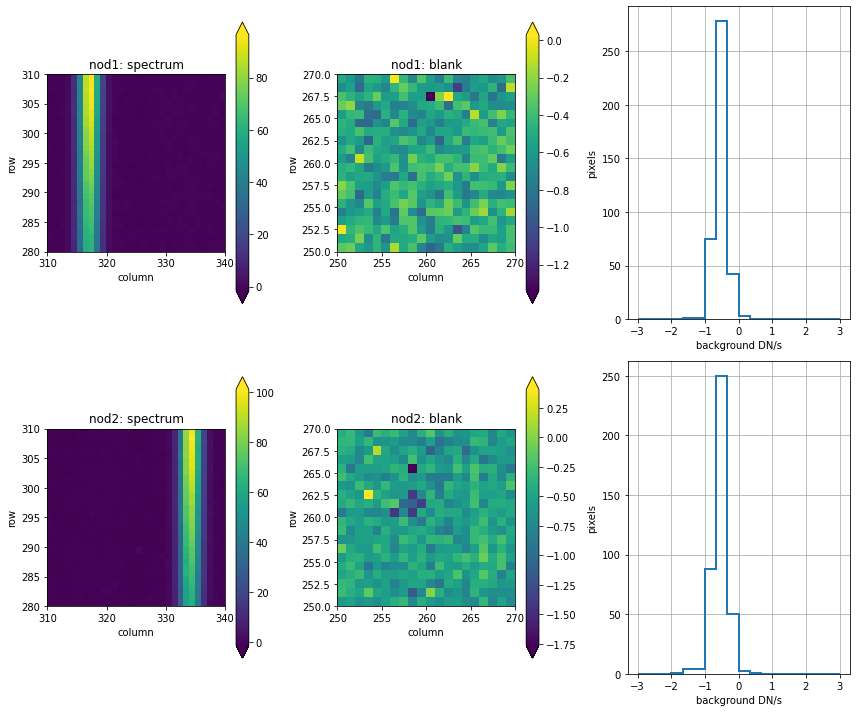

In [7]:
hdus = []
sci_ims = []
#nod_ims = ['nod 1', 'nod 2']
reg_spec = {'nod1':{'row1': 280, 'row2': 310, 'col1': 310, 'col2': 340}, 
            'nod2': {'row1': 280, 'row2': 310, 'col1': 310, 'col2': 340}}
reg_blank = {'nod1': {'row1': 250, 'row2': 270, 'col1': 250, 'col2': 270}, 
             'nod2': {'row1': 250, 'row2': 270, 'col1': 250, 'col2': 270}}


fig, ax = plt.subplots(ncols=3, nrows=2, figsize=[12,10])

for i,(aa, nn) in enumerate(zip(awcs_out, nods)):
    im = aa.data
    # PLOT THE TWO NODS: SPECTRUM AND BLANK REGION
    #print(i, aa, nn)
    
    implt0 = ax[i,0].imshow(im[reg_spec[nn]['row1']:reg_spec[nn]['row2'], reg_spec[nn]['col1']:reg_spec[nn]['col2']], extent=[reg_spec[nn]['col1'], reg_spec[nn]['col2'], reg_spec[nn]['row1'], reg_spec[nn]['row2']],origin='lower', interpolation='None')
    ax[i,0].set_xlabel('column')
    ax[i,0].set_ylabel('row')
    ax[i,0].set_title('{}: spectrum'.format(nn))
    cbar = fig.colorbar(implt0, extend='both', shrink=0.9, ax=ax[i,0])
    
    implt1 = ax[i,1].imshow(im[reg_blank[nn]['row1']:reg_blank[nn]['row2'], reg_blank[nn]['col1']:reg_blank[nn]['col2']], extent=[reg_blank[nn]['col1'], reg_blank[nn]['col2'], reg_blank[nn]['row1'], reg_blank[nn]['row2']],origin='lower', interpolation='None')
    ax[i,1].set_xlabel('column')
    ax[i,1].set_ylabel('row')
    ax[i,1].set_title('{}: blank'.format(nn))
    cbar = fig.colorbar(implt1, extend='both', shrink=0.9, ax=ax[i,1])
    
    hbins = np.linspace(-3., +3., 19)
    implt2 = ax[i,2].hist(np.ravel(im[reg_blank[nn]['row1']:reg_blank[nn]['row2'], reg_blank[nn]['col1']:reg_blank[nn]['col2']]), bins=hbins, histtype='step', lw=2)
    ax[i,2].set_xlabel('background DN/s')
    ax[i,2].set_ylabel('pixels')
    ax[i,2].grid()
    
    fig.tight_layout()

## Manual subtraction check

Let's subtract nod 2 from nod 1, and vice versa, to act as comparison data for the pipeline step.

2021-02-18 22:13:43,480 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



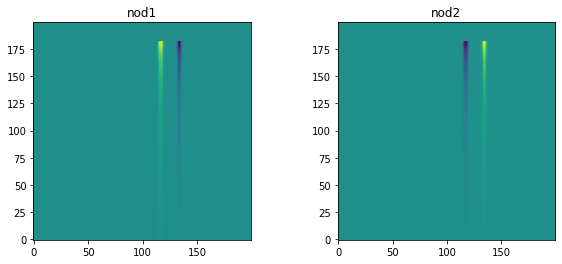

In [8]:
subcomp = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,4])

for i, aa in enumerate(awcs_out):
    if (i==0):
        bgr = awcs_out[1]
    else:
        bgr = awcs_out[0]
    
    sub = aa.data - bgr.data
    subcomp.append(sub)
    ax[i].imshow(sub[200:400, 200:400], origin='lower', interpolation='None')
    ax[i].set_title('{}'.format(nods[i]))            

## Pipeline step: BackgroundStep.call()

Now we run the background subtraction step. Nod 2 is the background for Nod 1, and vice versa. So we should end up with 2 outputs, each with a positive and negative spectral trace, and the background subtracted. 

This is the first method we try, using BackgroundStep.call(). This takes the following input:
- science file
- background file, or list of background files

i.e. this does _not_ take an association as input. We do the following in this next step:

* create an instance of the step
* set the output directory
* set up the logger to create an output logfile
* call the step, and save the output to the output directory

In [9]:
bgrstep = BackgroundStep()
subims = []
outdir = './point_slit_2dither/output_files/'

for i, aa in enumerate(awcs_out):
    print(i)

    if (i==0):
        bgr = awcs_out[1]
    elif (i==1):
        bgr = awcs_out[0]
    subim = bgrstep.call(aa, [bgr], save_results=True)
    subims.append(subim)

2021-02-18 22:13:43,637 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.


2021-02-18 22:13:43,649 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.


2021-02-18 22:13:43,735 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits>, [<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits>]).


2021-02-18 22:13:43,736 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}


0


2021-02-18 22:13:44,126 - stpipe.BackgroundStep - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_backgroundstep.fits


2021-02-18 22:13:44,127 - stpipe.BackgroundStep - INFO - Step BackgroundStep done


2021-02-18 22:13:44,139 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.


2021-02-18 22:13:44,228 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_assignwcsstep.fits>, [<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_assignwcsstep.fits>]).


2021-02-18 22:13:44,229 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}


1


2021-02-18 22:13:44,607 - stpipe.BackgroundStep - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_backgroundstep.fits


2021-02-18 22:13:44,607 - stpipe.BackgroundStep - INFO - Step BackgroundStep done


Compare the output against the manual check.

2021-02-18 22:13:44,611 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



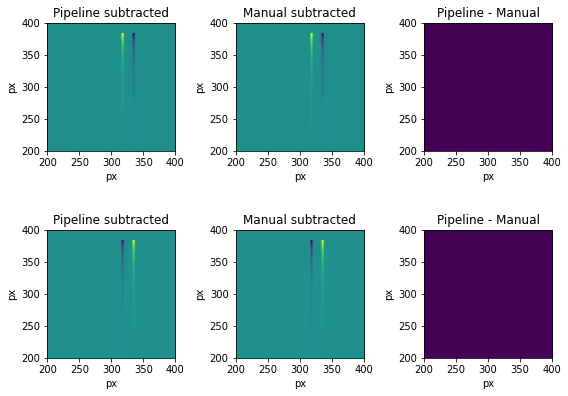

In [10]:
fig, _ax = plt.subplots(ncols=3, nrows=2, figsize=[8,6])
ax = _ax.flatten()

reg = [200, 400]

for i, (pp, cc) in enumerate(zip(subims, subcomp)):
    j = i*3
    ax[j].imshow(pp.data[reg[0]:reg[1], reg[0]:reg[1]], origin='lower', interpolation='None', extent=[reg[0], reg[1], reg[0], reg[1]])
    ax[j].set_title('Pipeline subtracted')
    ax[j].set_xlabel('px')
    ax[j].set_ylabel('px')
    ax[j+1].imshow(cc[reg[0]:reg[1], reg[0]:reg[1]], origin='lower', interpolation='None', extent=[reg[0], reg[1], reg[0], reg[1]])
    ax[j+1].set_title('Manual subtracted')
    ax[j+1].set_xlabel('px')
    ax[j+1].set_ylabel('px')
    ax[j+2].imshow(pp.data[reg[0]:reg[1], reg[0]:reg[1]]-cc[reg[0]:reg[1], reg[0]:reg[1]], origin='lower', interpolation='None', extent=[reg[0], reg[1], reg[0], reg[1]])
    ax[j+2].set_title('Pipeline - Manual')
    ax[j+2].set_xlabel('px')
    ax[j+2].set_ylabel('px')
    
    
    fig.tight_layout()

Compare histograms of the blank regions of science frames and subtracted frames. The two subtracted histograms should be the same and centred close(r) to zero than the background regions in the science frames.

MEAN VALUE OF BLANK SKY REGION BEFORE SUBTRACTION, nod1 = -0.5235
MEAN VALUE OF BLANK SKY REGION BEFORE SUBTRACTION, nod2 = -0.5431
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, PIPELINE SUBTRACTION, nod2 = 0.0196
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, MANUAL SUBTRACTION, nod2 = 0.0196
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, PIPELINE SUBTRACTION, nod2 = -0.0196
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, MANUAL SUBTRACTION, nod2 = -0.0196


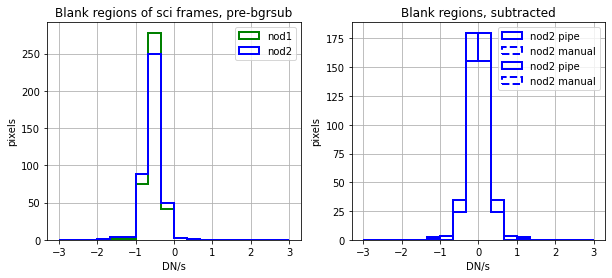

In [11]:
fig, _ax = plt.subplots(nrows=1, ncols=2, figsize=[10,4])
ax = _ax.flatten()

presub_mean = np.zeros(2, dtype=float)
sub_mean = np.zeros_like(presub_mean)
sub_mean_man = np.zeros_like(presub_mean)


for i, (aa, nn) in enumerate(zip(awcs_out, nods)):
    if '1' in nn:
        lab = 'nod1'
        cc = 'g'
    else:
        lab = 'nod2'
        cc = 'b'
    ax[0].hist(np.ravel(aa.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']]), bins=hbins, histtype='step', lw=2, color=cc, label=lab)
    ax[0].legend(prop={'size': 10})
    ax[0].set_title('Blank regions of sci frames, pre-bgrsub')
    ax[0].set_xlabel('DN/s')
    ax[0].set_ylabel('pixels')
    ax[0].grid(True)
    
    print('MEAN VALUE OF BLANK SKY REGION BEFORE SUBTRACTION, {0} = {1:.4f}'.format(lab, np.mean(aa.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])))
    
    presub_mean[i] = np.mean(aa.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])
    
    



for pp, cc in zip(subims, subcomp):
    if 'seq1' in pp.meta.filename:
        lab = 'nod1'
        col ='g'
    else:
        lab = 'nod2'
        col = 'b'
    ax[1].hist(np.ravel(pp.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']]), bins=hbins, histtype='step', lw=2, color=col, ls = '-', label=lab+' pipe')
    ax[1].hist(np.ravel(cc[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']]), bins=hbins, histtype='step', lw=2, color=col, ls = '--', label=lab+' manual')
    ax[1].legend(prop={'size': 10})
    ax[1].set_title('Blank regions, subtracted')
    ax[1].set_xlabel('DN/s')
    ax[1].set_ylabel('pixels')
    ax[1].grid(True)
    
    print('MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, PIPELINE SUBTRACTION, {0} = {1:.4f}'.format(lab, np.mean(pp.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])))
    print('MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, MANUAL SUBTRACTION, {0} = {1:.4f}'.format(lab, np.mean(cc[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])))
    
    sub_mean[i] = np.mean(pp.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])
    sub_mean_man[i] = np.mean(cc[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])

Now run the following checks:
* pipeline subtracted and manual check version should be almost identical
* the pipeline subtracted version should have a mean that is closer to zero than the pre-subtracted version (in absolute value)

If these assert statements PASS and plots back the findings up, the test is successful.


In [12]:
assert np.allclose(sub_mean, sub_mean_man), "Pipeline subtraction and manual check don't appear to match"
assert np.abs(presub_mean[0]) > np.abs(sub_mean[0]), "Post-background subtraction values appear to be higher than pre-subtraction; this is unexpected."
assert np.abs(presub_mean[1]) > np.abs(sub_mean[1]), "Post-background subtraction values appear to be higher than pre-subtraction; this is unexpected."

2021-02-18 22:13:45,277 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



### END

Authors: K. Murray (kmurray@stsci.edu), S. Kendrew (sarah.kendrew@esa.int) -- MIRI branch